/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 0, Reward: 7328, Epsilon: 0.28
Episode 5, Reward: 5860, Epsilon: 0.10
Episode 10, Reward: 4663, Epsilon: 0.10
Episode 15, Reward: 6215, Epsilon: 0.10
Episode 20, Reward: 3261, Epsilon: 0.10
Episode 25, Reward: 5032, Epsilon: 0.10


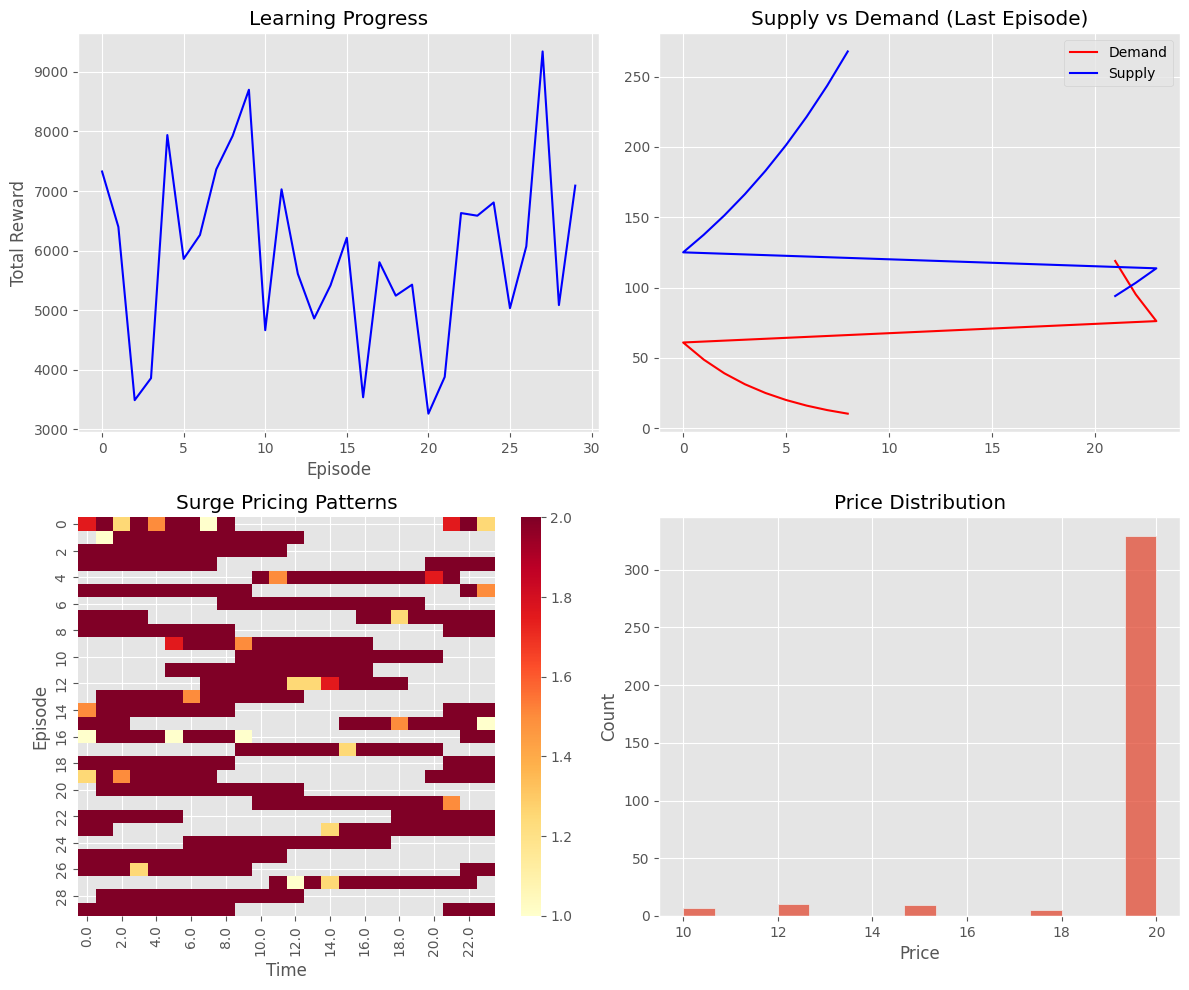


Performance Summary:
    Metric Overall Final Episode
 Avg Price  $19.44        $20.00
 Avg Surge   1.94x         2.00x
Avg Demand    41.9          46.1
Avg Supply   175.3         167.4


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class FastSurgePricingEnv:
    def __init__(self):
        self.base_price = 10.0

    def reset(self):
        self.demand = 100 + np.random.randn() * 20
        self.supply = 100 + np.random.randn() * 10
        self.time = np.random.randint(24)
        return np.array([self.demand/100, self.supply/100, self.time/24])  # Normalized state

    def step(self, surge):
        price = self.base_price * surge
        self.demand *= (1 - 0.2 * (surge - 1.0))
        self.supply *= (1 + 0.1 * (surge - 1.0))
        reward = min(self.demand, self.supply) * price - abs(self.demand - self.supply)
        self.time = (self.time + 1) % 24
        return np.array([self.demand/100, self.supply/100, self.time/24]), reward

class FastDQNAgent:
    def __init__(self, state_size=3, action_size=5):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.1
        self.model = Sequential([
            Dense(8, activation='relu', input_dim=state_size),
            Dense(action_size, activation='linear')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(5)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0)[0])

    def train(self, state, action, reward, next_state):
        target = reward + 0.95 * np.max(self.model.predict(next_state.reshape(1, -1), verbose=0)[0])
        target_f = self.model.predict(state.reshape(1, -1), verbose=0)
        target_f[0][action] = target
        self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training
env = FastSurgePricingEnv()
agent = FastDQNAgent()
surge_values = np.array([1.0, 1.25, 1.5, 1.75, 2.0])
episodes = 30
history = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    episode_data = []

    for step in range(12):  # Reduced steps per episode
        action = agent.act(state)
        surge = surge_values[action]
        next_state, reward = env.step(surge)

        agent.train(state, action, reward, next_state)
        total_reward += reward

        episode_data.append({
            'Episode': episode,
            'Time': state[2] * 24,  # Denormalize time
            'Demand': state[0] * 100,  # Denormalize demand
            'Supply': state[1] * 100,  # Denormalize supply
            'Surge': surge,
            'Price': surge * env.base_price,
            'Reward': reward
        })

        state = next_state

    history.extend(episode_data)
    if episode % 5 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.0f}, Epsilon: {agent.epsilon:.2f}")

# Analysis and Visualization
df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Learning Progress
rewards = df.groupby('Episode')['Reward'].sum()
axes[0, 0].plot(rewards.index, rewards.values, 'b-')
axes[0, 0].set_title('Learning Progress')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')

# 2. Final Episode Analysis
last_ep = df[df['Episode'] == episodes-1]
axes[0, 1].plot(last_ep['Time'], last_ep['Demand'], 'r-', label='Demand')
axes[0, 1].plot(last_ep['Time'], last_ep['Supply'], 'b-', label='Supply')
axes[0, 1].set_title('Supply vs Demand (Last Episode)')
axes[0, 1].legend()

# 3. Surge Pricing Pattern
surge_pivot = df.pivot_table(values='Surge', index='Episode', columns='Time', aggfunc='mean')
sns.heatmap(surge_pivot, ax=axes[1, 0], cmap='YlOrRd')
axes[1, 0].set_title('Surge Pricing Patterns')

# 4. Price Distribution
sns.histplot(data=df, x='Price', ax=axes[1, 1], bins=15)
axes[1, 1].set_title('Price Distribution')

plt.tight_layout()
plt.show()

# Summary Statistics
summary = pd.DataFrame({
    'Metric': ['Avg Price', 'Avg Surge', 'Avg Demand', 'Avg Supply'],
    'Overall': [
        f"${df['Price'].mean():.2f}",
        f"{df['Surge'].mean():.2f}x",
        f"{df['Demand'].mean():.1f}",
        f"{df['Supply'].mean():.1f}"
    ],
    'Final Episode': [
        f"${last_ep['Price'].mean():.2f}",
        f"{last_ep['Surge'].mean():.2f}x",
        f"{last_ep['Demand'].mean():.1f}",
        f"{last_ep['Supply'].mean():.1f}"
    ]
})

print("\nPerformance Summary:")
print(summary.to_string(index=False))